In [511]:
import numpy as np
import pandas as pd 
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from numpy import linspace
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

# Read the cleaned data
trainDataOriginal = pd.read_csv('train_data.csv')
# testDataOriginal = pd.read_csv('test_data.csv')

In [512]:
trainData = trainDataOriginal[trainDataOriginal['balls_remaining'] < 300]
testData = testDataOriginal[testDataOriginal['balls_remaining'] < 300]

# trainData = trainData[trainData['balls_remaining'] > 240]
# testData = trainData[trainData['balls_remaining'] > 240]

# trainData = trainData.drop(['final_score', 'over', 'wickets', 'wickets_remaining'], axis=1)
# testData = testData.drop(['final_score', 'over', 'wickets', 'wickets_remaining'], axis=1)

trainData = trainData[trainData['inning'] == 1]
testData = testData[testData['inning'] == 1]


NameError: name 'testDataOriginal' is not defined

In [538]:
allData = trainDataOriginal[((trainDataOriginal['year'] <= 2011) & (trainDataOriginal['year'] > 2008)) | 
                              ((trainDataOriginal['year'] == 2012) & (trainDataOriginal['month'] <= 7)) ]

# allData = trainDataOriginal[(trainDataOriginal['year'] <= 2017) & (trainDataOriginal['year'] > 2012)]

# allData = allData[allData['balls_remaining'] <= 30]


allData = allData[allData['inning'] == 1]
innings = allData['innings_no'].unique()
len(innings)

inningsViceData = {}
for inning in innings:
    inningData = allData[allData['innings_no'] == inning]
    if inningData['over'].iloc[-1] != 50:
        continue

    inningsViceData[inning] = inningData

# Split the train and test set
trainList = []
testList = []
trainDataCount = len(inningsViceData) - 25
count = 0;
for key, value in inningsViceData.items():
    if(count < trainDataCount):
        trainList.append(value)
    else:
        testList.append(value)
    count += 1
    
trainData = pd.concat(trainList, ignore_index=True)
testData = pd.concat(testList, ignore_index=True)


a = trainData.groupby(['innings_no']).last()
b = testData.groupby(['innings_no']).last()
print (a.shape, b.shape)

(230, 38) (25, 38)


In [526]:
# define the model
def deep_model():
    # create model
    model = Sequential()
#     8,1 is the best so far
    model.add(Dense(1024, input_shape=(24,), activation='sigmoid'))
    model.add(Dense(256, activation='sigmoid'))
#     model.add(Dense(128, activation='sigmoid'))
    model.add(Dense(32, activation='sigmoid'))
#     model.add(Dense(4, activation='sigmoid'))
    model.add(Dense(1, kernel_initializer='normal'))
#     model.add(Dense(1, kernel_initializer='random_normal'))


    
    # Compile model
    model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae', 'mape', 'cosine'])
    return model

In [527]:
# y = trainData['run_scored'].astype(int).values
y = trainData['run_scored']
x = trainData.drop(['run_scored'], axis=1)

cat_features = ['country_Australia','country_Bangladesh','country_England','country_India','country_New Zealand',
                'country_Pakistan','country_South Africa','country_Sri Lanka','country_West Indies',
                'country_Zimbabwe','opponent_Australia','opponent_Bangladesh','opponent_England','opponent_India',
                'opponent_New Zealand','opponent_Pakistan','opponent_South Africa','opponent_Sri Lanka',
                'opponent_West Indies','opponent_Zimbabwe']

# cat_features = ['country_Australia','country_Bangladesh','country_England','country_India','country_New Zealand',
#                 'country_Pakistan','country_South Africa','country_Sri Lanka','country_West Indies',
#                 'country_Zimbabwe']

# cat_features = []

required_features = ['last_five_runrate','current_score', 'balls_remaining', 'wickets_remaining']

class ColumnExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_cols = X[self.columns]
        return X_cols

# feature_selection = FeatureUnion([
#                         ('num', Pipeline([('extract', ColumnExtractor(columns=required_features)),
#                                            ('poly', PolynomialFeatures(2))])),
#                         ('cat_var', ColumnExtractor(columns=cat_features))]);
feature_selection = FeatureUnion([
                        ('num', Pipeline([('extract', ColumnExtractor(columns=required_features))])),
                        ('cat_var', ColumnExtractor(columns=cat_features))]);

mlp = KerasRegressor(build_fn=deep_model)

featurePipeline = Pipeline([
                ('features', feature_selection),
                ('standardizer', MinMaxScaler()),
            ])


seed = 7
np.random.seed(seed)
kfold = KFold(n_splits=4, random_state=seed)


In [528]:
#  Use k-fold CV
# results = cross_val_score(pipeline, x, y, cv=kfold)
# print("Larger: %.2f (%.2f) MSE" % (results.mean(), results.std()))

In [529]:
def plot_history(model):
  plt.figure(1, figsize = (12, 8))
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [1000$]')
  plt.plot(model.epoch, np.array(model.history['mean_squared_error']),
           label='Train Loss')
  plt.plot(model.epoch, np.array(model.history['val_mean_squared_error']),
           label = 'Validation loss')
  plt.legend()


In [530]:
transformed_x= featurePipeline.fit_transform(x)

minMaxScalar = MinMaxScaler();
y = y.reshape(-1, 1)
transformed_y = minMaxScalar.fit_transform(y)

/media/supun/Data/softwares/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.
/media/supun/Data/softwares/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [531]:
mlp = KerasRegressor(build_fn=deep_model)

# batch_size=80
# batch_size=250
model = mlp.fit(transformed_x, transformed_y, epochs=20, validation_split=0.2, batch_size=250, verbose=3)

print('Done!')

Train on 5685 samples, validate on 1422 samples
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Done!


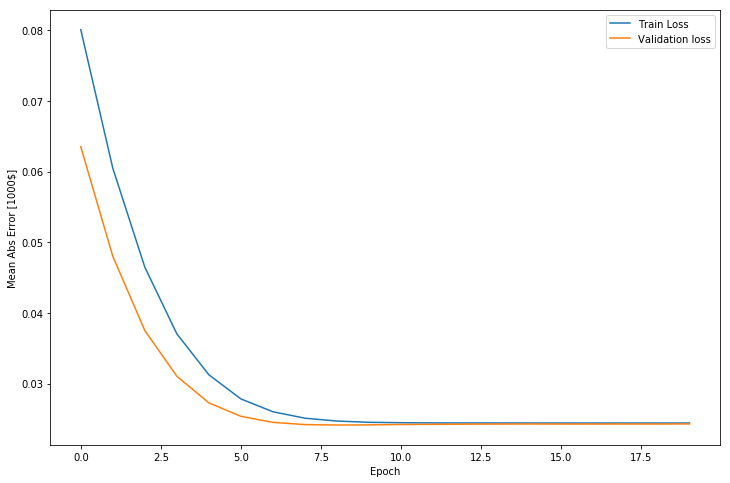

In [533]:
plot_history(model)
# model.history

In [534]:
# Validate
validateData = testData
# validateData = trainData

# validateData = validateData[validateData['innings_no'] > 1800]
validateData.reset_index(drop=True, inplace=True)

# validateData = testData
y_test = validateData['run_scored'].values
x_test = validateData.drop(['run_scored'], axis=1)

transformed_x_test = featurePipeline.fit_transform(x_test)
y_hat = mlp.predict(transformed_x_test)
y_hat = minMaxScalar.inverse_transform(y_hat.reshape(-1, 1))

results = pd.DataFrame()
results['actual'] = y_test
results['prediction'] = y_hat
results.reset_index(drop=True, inplace=True)

In [535]:
mse = mean_squared_error(y_test, y_hat);
print('MSE', mse)
print('RMSE', np.sqrt(mse))

MSE 203.53211263577535
RMSE 14.266468120588758


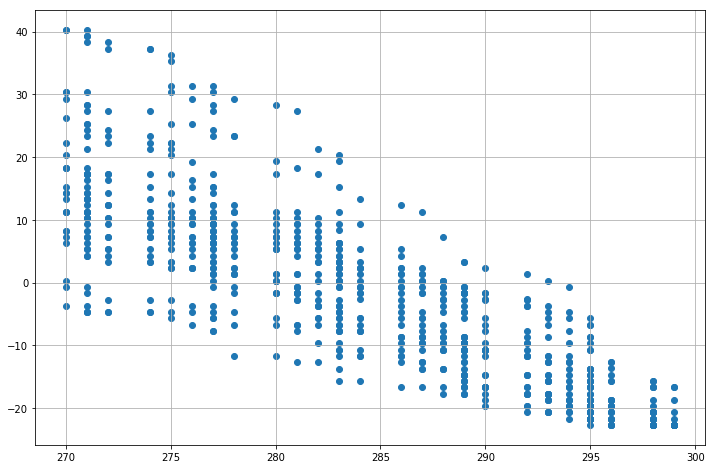

In [536]:
# compare = pd.DataFrame()
# compare['actualTotal'] = validateData['current_score'] + results['actual']
# compare['predictedTotal'] = validateData['current_score'] + results['prediction']

# import matplotlib.pyplot as plt

# # plt.figure(1, figsize = (12, 8))
# plt.scatter(300 - validateData['balls_remaining'], results['actual'] - results['prediction'])
# plt.grid()

compare = pd.DataFrame()
compare['actualTotal'] = validateData['current_score'] + results['actual']
compare['predictedTotal'] = validateData['current_score'] + results['prediction']

plt.figure(1, figsize = (12, 8))
plt.scatter(300 - validateData['balls_remaining'], results['actual'] - results['prediction'])
plt.grid()

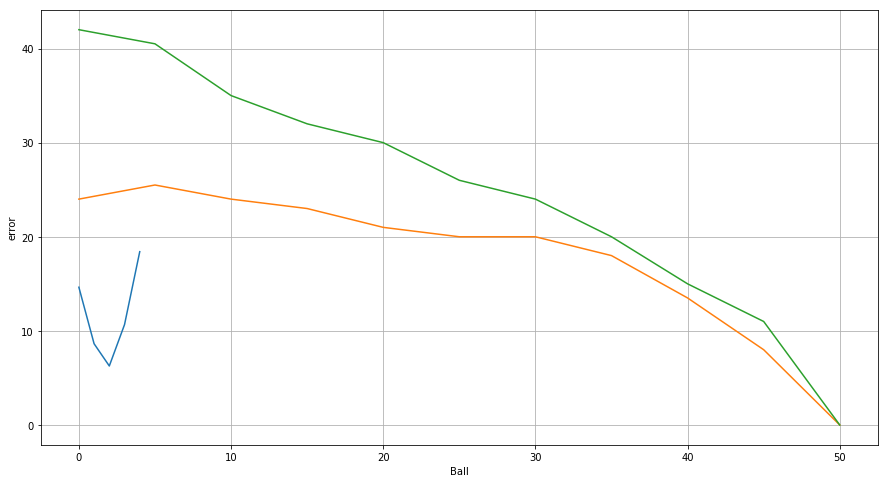

In [537]:
compare = pd.DataFrame()
compare['balls'] = 300 - validateData['balls_remaining']
compare['error'] = (results['actual'] - results['prediction']).abs()
compare['overs'] = (compare['balls'] / 6).astype(int)


comparePerBall = compare.groupby(['balls'], as_index=False).mean()
comparePerOver = compare.groupby(['overs'], as_index=False).mean()

plt.figure(1, figsize = (15, 8))
plt.clf()
# plt.scatter(comparePerOver['balls'], comparePerOver['error'])

comparePerOver['error'].plot()
plt.xlabel('Ball')
plt.ylabel('error')

# PLot the datamining aproach results to comprae as our base model
t = linspace(0, 50, 11)
# t = [0, 5, 10]
dmModel = [24, 25.5, 24, 23, 21, 20, 20, 18, 13.5, 8, 0]
baileyModel = [42, 40.5, 35, 32, 30, 26, 24, 20, 15, 11, 0]

# dmModel = [13.5, 8, 0]
overs = pd.DataFrame(t)
plt.plot(t, dmModel)
plt.plot(t, baileyModel)
plt.grid()
plt.show()

In [488]:
y = trainDataOriginal[trainDataOriginal['balls_remaining'] == 299]
y = y[y['run_scored']>0]
y[['current_score', 'balls_remaining', 'wickets_remaining','run_scored']]
trainDataOriginal

,inning,over,batting_team,current_score,wicket,wickets,innings_no,final_score,balls_remaining,wickets_remaining,...,opponent_Australia,opponent_Bangladesh,opponent_England,opponent_India,opponent_New Zealand,opponent_Pakistan,opponent_South Africa,opponent_Sri Lanka,opponent_West Indies,opponent_Zimbabwe
0,1,1,New Zealand,0,0,0,2,224,299,10,...,0,0,0,0,0,0,0,1,0,0
1,1,1,New Zealand,0,0,0,2,224,298,10,...,0,0,0,0,0,0,0,1,0,0
2,1,1,New Zealand,0,0,0,2,224,297,10,...,0,0,0,0,0,0,0,1,0,0
3,1,1,New Zealand,0,0,0,2,224,296,10,...,0,0,0,0,0,0,0,1,0,0
4,1,1,New Zealand,0,0,0,2,224,295,10,...,0,0,0,0,0,0,0,1,0,0
5,1,1,New Zealand,4,0,0,2,224,294,10,...,0,0,0,0,0,0,0,1,0,0
6,1,2,New Zealand,5,0,0,2,224,293,10,...,0,0,0,0,0,0,0,1,0,0
7,1,2,New Zealand,6,0,0,2,224,292,10,...,0,0,0,0,0,0,0,1,0,0
8,1,2,New Zealand,10,0,0,2,224,291,10,...,0,0,0,0,0,0,0,1,0,0
9,1,2,New Zealand,10,0,0,2,224,290,10,...,0,0,0,0,0,0,0,1,0,0
